# MNIST Handwritten Digit Classification

## Abstract

In this notebook we play a bit with the MNIST dataset. The goal is to learn a simple example of classification of handwritten digits using various techniques and serve as an introduction to Tensorflow. We compare the accuracy and the required training time for Neural Networks of different number of Hidden Units. We also compare a few different optimizers.


---

## Table of Contents

1. **Install Modules**
2. **Dataloader, Transform**
4. **Modeling the NN**
5. **Loss and Optimizer**
6. **Training**
7. **Model Evaluation**
8. **Testing the accuracy**

## Install Libraries

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, Input, Dense, MaxPool2D, BatchNormalization, GlobalAvgPool2D
import matplotlib.pyplot as plt
#Other useful libraries
import os

## Load the Data

In [2]:
# Load the MNIST dataset #x_train_0.shape
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

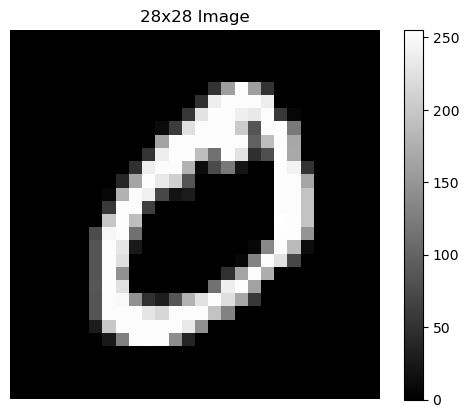

In [3]:
image_test = x_train[1]
plt.imshow(x_train[1], cmap='gray')
plt.colorbar()  # Optionally add a colorbar
plt.title('28x28 Image')
plt.axis('off')  # Optionally turn off axis
plt.show()


In [3]:
# Normalize the data We can verify by 
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


# Flatten the input data
x_train = x_train.reshape(-1, 28 * 28)  # Reshape to (num_samples, 784)
x_test = x_test.reshape(-1, 28 * 28)

# Convert labels to one-hot encoding using vectors of dimension D=10
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)



## Modeling the NN

In [4]:
class SingleLayerFFN(tf.Module):
    def __init__(self, input_dim, output_dim):
        # Initialize weights and biases
        self.w = tf.Variable(tf.random.normal([input_dim, output_dim],stddev=0.1), name="w")
        self.b = tf.Variable(tf.random.normal([output_dim],stddev=0.1),  name="b")

    def __call__(self, x):
        # Forward pass: Linear transformation followed by softmax
        logits = tf.matmul(x, self.w) + self.b
        return tf.nn.softmax(logits)
model1 = SingleLayerFFN(28*28, 10)

In [5]:
class TwoLayerFFN(tf.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        # Initialize weights and biases for the hidden layer
        # We use tf.Variable for those parameters to be optimized
        self.w1 = tf.Variable(tf.random.normal([input_dim, hidden_dim],stddev=0.1), name="w1")
        self.b1 = tf.Variable(tf.random.normal([hidden_dim],stddev=0.1),  name="b1")
        
        # Initialize weights and biases for the output layer
        self.w2 = tf.Variable(tf.random.normal([hidden_dim, output_dim],stddev=0.1),  name="w2")
        self.b2 = tf.Variable(tf.random.normal([output_dim],stddev=0.1),  name="b2")

    def __call__(self, x):
        # Forward pass through the hidden layer
        hidden_output = tf.nn.relu(tf.matmul(x, self.w1) + self.b1)
        
        # Forward pass through the output layer
        logits = tf.matmul(hidden_output, self.w2) + self.b2
        return tf.nn.softmax(logits)

model2 = TwoLayerFFN(28*28, 128, 10)
#tf.reduce_sum(model(x_train[1: 2])).numpy() Check sum is 1

## Loss and Optimizer

In [6]:
# Define loss and optimizer
def cross_entropy_loss(y_true, y_pred):
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-9), axis=1))

#optimizer = tf.optimizers.Adam(learning_rate)
learning_rate = 0.001
optimizer = tf.optimizers.Adam(learning_rate)
#optimizer = tf.optimizers.SGD(learning_rate)

## Training

In [7]:
# Train the model
num_epochs = 5
batch_size = 32
num_batches = int(np.ceil(x_train.shape[0] / batch_size))

### Single Layer

In [8]:
# Training loop
for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        with tf.GradientTape() as tape:
            y_pred = model1(x_batch)
            loss = cross_entropy_loss(y_batch, y_pred)
           
        gradients = tape.gradient(loss, [model1.w, model1.b])
        optimizer.apply_gradients(zip(gradients, [model1.w, model1.b]))

    # Compute accuracy on the training set
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")

Epoch 1, Loss: 0.13856856524944305
Epoch 2, Loss: 0.11117905378341675
Epoch 3, Loss: 0.10272729396820068
Epoch 4, Loss: 0.09894952178001404
Epoch 5, Loss: 0.09704163670539856


In [9]:
save_path = os.getcwd()

# Create a dictionary of the model's weights and biases
model1_weights = {
    "w": model1.w.numpy(),
    "b": model1.b.numpy()
}

# Save the model's weights and biases as a .npz file
np.savez(save_path + "model1_weights.npz", **model1_weights)

In [11]:
load_path = os.getcwd()
# Load the weights and biases from the .npz file
loaded_weights = np.load(load_path + "model1_weights.npz")

# Reassign the loaded weights and biases to your model
model1.w = tf.Variable(loaded_weights["w"])
model1.b = tf.Variable(loaded_weights["b"])

### Two Layer

In [9]:
# Training loop
for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        with tf.GradientTape() as tape:
            y_pred = model2(x_batch)
            loss = cross_entropy_loss(y_batch, y_pred)
           
        gradients = tape.gradient(loss, [model2.w1, model2.b1, model2.w2, model2.b2])
        optimizer.apply_gradients(zip(gradients, [model2.w1, model2.b1, model2.w2, model2.b2]))

    # Compute accuracy on the training set
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")


Epoch 1, Loss: 0.06319397687911987
Epoch 2, Loss: 0.03785952925682068
Epoch 3, Loss: 0.03313295543193817
Epoch 4, Loss: 0.022019298747181892
Epoch 5, Loss: 0.013361007906496525


In [13]:
save_path = os.getcwd()

# Create a dictionary of the model's weights and biases
model_weights = {
    "w1": model2.w1.numpy(),
    "b1": model2.b1.numpy(),
    "w2": model2.w2.numpy(),
    "b2": model2.b2.numpy()
}

# Save the model's weights and biases as a .npz file
np.savez(save_path + "model_weights.npz", **model_weights)

In [5]:
load_path = os.getcwd()
# Load the weights and biases from the .npz file
loaded_weights = np.load(load_path + "model_weights.npz")

# Reassign the loaded weights and biases to your model
model2.w1 = tf.Variable(loaded_weights["w1"])
model2.b1 = tf.Variable(loaded_weights["b1"])
model2.w2 = tf.Variable(loaded_weights["w2"])
model2.b2 = tf.Variable(loaded_weights["b2"])

## Model Evaluation

### Single Layer

In [10]:
# Evaluate the model
def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1)
    correct_labels = tf.argmax(labels, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, correct_labels), tf.float32))
    return accuracy

logits_test = model1(x_test)
test_accuracy = accuracy(logits_test, y_test)
print(f"Single Layer Accuracy: {test_accuracy.numpy()}")


logits_test = model2(x_test)
test_accuracy = accuracy(logits_test, y_test)
print(f"Two Layer Accuracy: {test_accuracy.numpy()}")

Single Layer Accuracy: 0.9236000180244446
Two Layer Accuracy: 0.9761999845504761
